In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image
import skimage

Using TensorFlow backend.


In [5]:
path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
#path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"

model = load_model(path + 'models/' + 'EDGEnet2_int_L1_epoch_4.h5')
#model = load_model(path + 'models\\' + 'EDGEnet2_int_L1_epoch_4.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1024, 64, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 64, 64)      256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 64, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1024, 64, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024, 64, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024, 64, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1024, 64, 64)      36928     
__________

In [13]:
sigma = 1.4
alpha = 0.7
Xi = 10
width = 20
space = 40
noise = 20
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 

original_file = path + 'original_images/oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images/nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'
imnoisy = np.array(Image.open(noisy_file))
im = np.array(Image.open(original_file))

imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)

linepredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
linepredict = linepredict.reshape(1024,2)
print(linepredict.shape)

(1024, 2)


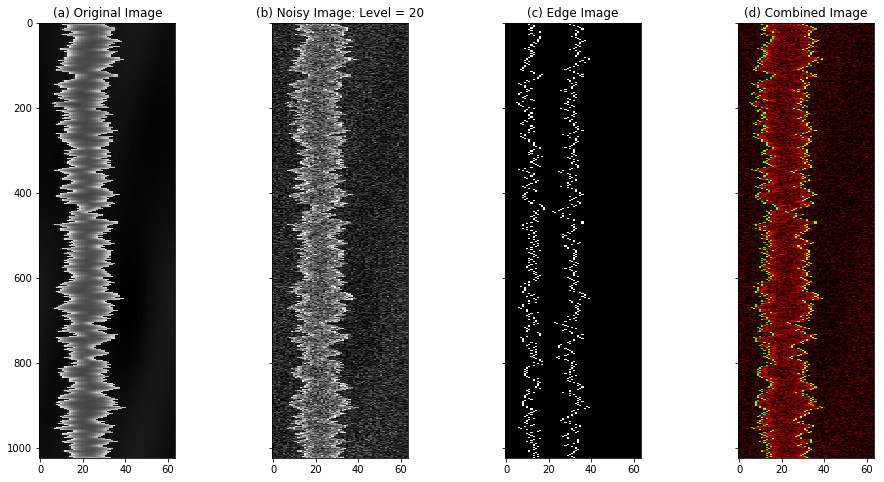

In [14]:

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

ax[0].imshow(im,cmap = 'gray',aspect= 0.2)
ax[0].set_title('(a) Original Image')

ax[1].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[1].set_title('(b) Noisy Image: Level = {}'.format(noise))

edgepredict = np.zeros((1024,64))
i =[]
for i in range(1024):
    edgepredict[i, (linepredict*64).round().astype(int)[i,0]] = 1
    edgepredict[i, (linepredict*64).round().astype(int)[i,1]] = 1
    
ax[2].imshow(edgepredict, cmap = 'gray',aspect= 0.2)
ax[2].set_title('(c) Edge Image')

combine = np.zeros((1024,64,3))
combine[:,:,0] = imnoisy
combine[:,:,1] = edgepredict

ax[3].imshow(combine, cmap = 'gray', aspect= 0.2)
ax[3].set_title('(d) Combined Image')

plt.show()


Original leftline sigma = 1.2808688457449497, rightline sigma = 1.409712534068892
Predicted leftline sigma = 1.2749231016119378, rightline sigma = 1.3896367708575625
87
98
Mean absolute position error = 0.09033203125
Original LWR = 1.9247905666814604 
Predicted LWR = 1.9170207304731586 


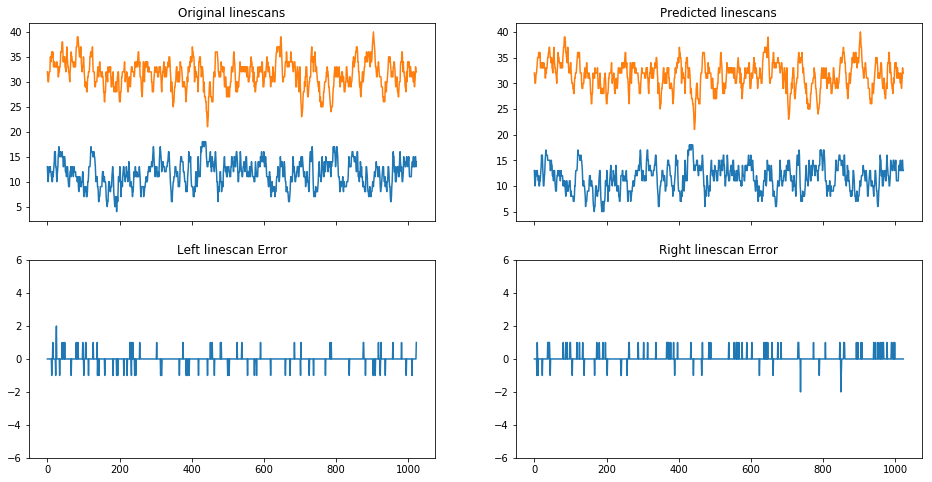

In [15]:
linescan_file = path + 'linescans/linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for i, line in enumerate(f):
        if i < 3000:
            a, b = line.split(',')
            linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8), sharex=True,
                       sharey=False, subplot_kw={'adjustable': 'box-forced'})


print('Original leftline sigma = {}, rightline sigma = {}'.format(leftline.astype(int).std()/2, \
                                                                  rightline.astype(int).std()/2))

print('Predicted leftline sigma = {}, rightline sigma = {}'.format((linepredict*64).round().astype(int)[:,0].std()/2, \
                                                                  (linepredict*64).round().astype(int)[:,1].std()/2))

left_error = np.abs(leftline.astype(int) - (linepredict*64).round().astype(int)[:,0]).sum()
right_error = np.abs(rightline.astype(int) - (linepredict*64).round().astype(int)[:,1]).sum()
print(left_error)
print(right_error)
print('Mean absolute position error = {}'.format((left_error + right_error)/2048))
print('Original LWR = {} '.format((rightline.astype(int) - leftline.astype(int)).std()/2))
print('Predicted LWR = {} '.format(((linepredict*64).round().astype(int)[:,0] - (linepredict*64).round().astype(int)[:,1]).std()/2))

ax[0,0].plot(leftline.astype(int))
ax[0,0].plot(rightline.astype(int))
ax[0,0].set_title('Original linescans')

ax[0,1].plot((linepredict*64).round().astype(int))
ax[0,1].set_title('Predicted linescans')

ax[1,0].plot(leftline.astype(int) - (linepredict*64).round().astype(int)[:,0])
ax[1,0].set_title('Left linescan Error')
ax[1,0].set_ylim([-6,6])

ax[1,1].plot(rightline.astype(int) - (linepredict*64).round().astype(int)[:,1])
ax[1,1].set_title('Right linescan Error')
ax[1,1].set_ylim([-6,6])

plt.show()